# Aidan Elliott

## Research Question

#### Most scientists agree that climate change has been significantly accelerated due to human expansion. The rate at which countries emmit C02 varies greatly due to population, gdp, etc. However, I want to explore whether the more carbon a country emits affects their increase in temperature locally greater than their global affect. We can get significant insight to this question by examining a dataset containing emission data by country over time with another dataset tracking average temperature by country over time.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import seaborn as sns
import mapclassify

# Cleaning Dataset

In [ ]:
df_em = pd.read_csv("../data/raw/owid_emissions.csv") #Emissions dataframe
df_em

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1850,AFG,3752993.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.121,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1851,AFG,3769828.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.118,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1852,AFG,3787706.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.116,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1853,AFG,3806634.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.115,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1854,AFG,3825655.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.114,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46518,Zimbabwe,2017,ZWE,14751101.0,2.194784e+10,0.469,0.032,9.596,-0.937,-8.899,...,NaN,0.0,0.0,0.219,0.026,NaN,115.59,28.30,0.910,9.486
46519,Zimbabwe,2018,ZWE,15052191.0,2.271535e+10,0.558,0.037,11.795,2.199,22.920,...,NaN,0.0,0.0,0.211,0.033,NaN,118.22,30.83,0.771,6.537
46520,Zimbabwe,2019,ZWE,15354606.0,NaN,0.570,0.037,11.115,-0.681,-5.772,...,NaN,0.0,0.0,0.183,0.030,NaN,117.96,30.53,0.978,8.795
46521,Zimbabwe,2020,ZWE,15669663.0,NaN,0.570,0.036,10.608,-0.507,-4.559,...,NaN,0.0,0.0,0.194,0.030,NaN,NaN,NaN,1.006,9.481


#### The goal for my dataset is to combine the CO2 and temperature dataset for every country on the globe. Using geopandas, I can preload a world dataset that contains some basic information about every country in the world. The dataset also contains the geometry of every country which will help us later for making world plots with a simple line of code.

In [ ]:
#Read in world dataframe which contains geometry of countries to plot with geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')).sort_values(by=["name"]).reset_index()
world.index = world["name"]
world.drop(["index","iso_a3"],axis=1,inplace=True)
world

,pop_est,continent,name,gdp_md_est,geometry
name,,,,,
Afghanistan,38041754.0,Asia,Afghanistan,19291,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
Albania,2854191.0,Europe,Albania,15279,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
Algeria,43053054.0,Africa,Algeria,171091,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948..."
Angola,31825295.0,Africa,Angola,88815,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
Antarctica,4490.0,Antarctica,Antarctica,898,"MULTIPOLYGON (((-48.66062 -78.04702, -48.15140..."
...,...,...,...,...,...
W. Sahara,603253.0,Africa,W. Sahara,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
Yemen,29161922.0,Asia,Yemen,22581,"POLYGON ((52.00001 19.00000, 52.78218 17.34974..."
Zambia,17861030.0,Africa,Zambia,23309,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458..."


### Cleaning Emission Data

In [ ]:
#Drop data before 1960
emissions = df_em.drop(df_em[df_em["year"] < 1960].index)
#Replace some country names from emissions dataframe to match ones in world df
emissions.replace({"United States":"United States of America",
                  "Bosnia and Herzegovina": "Bosnia and Herz.",
                  'Democratic Republic of Congo':'Dem. Rep. Congo',
                  "Equatorial Guinea":"Eq. Guinea",
                  'South Sudan':'S. Sudan',
                  'Central African Republic':'Central African Rep.',
                  "Cote d'Ivoire":"Côte d'Ivoire",
                  'Western Sahara':'W. Sahara',
                  'Eswatini':'eSwatini',
                  "Somalia":'Somaliland'}, inplace=True)
emissions

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
110,Afghanistan,1960,AFG,8622473.0,1.303325e+10,0.018,0.002,0.414,0.029,7.623,...,NaN,0.0,0.0,0.275,0.009,NaN,NaN,NaN,NaN,NaN
111,Afghanistan,1961,AFG,8790140.0,1.314629e+10,0.022,0.002,0.491,0.077,18.583,...,NaN,0.0,0.0,0.261,0.009,NaN,NaN,NaN,NaN,NaN
112,Afghanistan,1962,AFG,8969055.0,1.336763e+10,0.029,0.003,0.689,0.198,40.301,...,NaN,0.0,0.0,0.242,0.010,NaN,NaN,NaN,NaN,NaN
113,Afghanistan,1963,AFG,9157463.0,1.363030e+10,0.051,0.006,0.707,0.018,2.635,...,NaN,0.0,0.0,0.250,0.010,NaN,NaN,NaN,NaN,NaN
114,Afghanistan,1964,AFG,9355510.0,1.387050e+10,0.062,0.007,0.839,0.132,18.651,...,NaN,0.0,0.0,0.205,0.012,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46518,Zimbabwe,2017,ZWE,14751101.0,2.194784e+10,0.469,0.032,9.596,-0.937,-8.899,...,NaN,0.0,0.0,0.219,0.026,NaN,115.59,28.30,0.910,9.486
46519,Zimbabwe,2018,ZWE,15052191.0,2.271535e+10,0.558,0.037,11.795,2.199,22.920,...,NaN,0.0,0.0,0.211,0.033,NaN,118.22,30.83,0.771,6.537
46520,Zimbabwe,2019,ZWE,15354606.0,NaN,0.570,0.037,11.115,-0.681,-5.772,...,NaN,0.0,0.0,0.183,0.030,NaN,117.96,30.53,0.978,8.795
46521,Zimbabwe,2020,ZWE,15669663.0,NaN,0.570,0.036,10.608,-0.507,-4.559,...,NaN,0.0,0.0,0.194,0.030,NaN,NaN,NaN,1.006,9.481


In [ ]:
#Pivot so each country is a row and each column is the year
pivot_em = emissions.pivot(index="country",columns=["year"],values=["co2"])
#Drop any countries from the emissions dataframe that is not in the geopandas dataframe
pivot_em = pivot_em[pivot_em.index.isin(world["name"].unique().tolist())]
pivot_em

co2                                                           \
year          1960   1961   1962   1963   1964   1965   1966   1967    1968   
country                                                                       
Afghanistan  0.414  0.491  0.689  0.707  0.839  1.007  1.091  1.282   1.223   
Albania      2.022  2.279  2.462  2.081  2.015  2.172  2.550  2.677   3.069   
Algeria      6.151  6.056  5.661  5.419  5.643  6.589  8.421  8.432   9.050   
Angola       0.549  0.454  1.179  1.150  1.223  1.186  1.552  0.992   1.670   
Antarctica     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
...            ...    ...    ...    ...    ...    ...    ...    ...     ...   
W. Sahara      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
Yemen        3.631  2.664  3.884  2.917  3.631  3.928  3.462  3.052  11.637   
Zambia       4.355  3.709  3.583  3.444  3.275  3.912  3.498  4.788   4.568   
Zimbabwe     5.943  5.061  4.889  4.700  4.469  5.209  6.041  5.294   6.378   
eSwatini     0.033  0.004    NaN    NaN  0.011  0.081  0.202  0.227   0.278   

                     ...                                               \
year           1969  ...     2012     2013     2014     2015     2016   
country              ...                                                
Afghanistan   0.941  ...   10.035    9.251    9.170    9.791    9.068   
Albania       3.241  ...    4.850    5.287    6.000    4.712    4.632   
Algeria      11.263  ...  135.674  140.786  151.283  160.087  158.748   
Angola        2.783  ...   25.540   24.719   25.148   25.531   27.210   
Antarctica      NaN  ...      NaN      NaN      NaN      NaN      NaN   
...             ...  ...      ...      ...      ...      ...      ...   
W. Sahara       NaN  ...      NaN      NaN      NaN      NaN      NaN   
Yemen         4.675  ...   20.356   27.160   26.477   14.084   10.902   
Zambia        4.271  ...    4.166    4.416    4.877    5.065    5.857   
Zimbabwe      6.744  ...   11.254   11.671   11.946   12.255   10.533   
eSwatini      0.304  ...    1.169    1.400    0.769    0.868    1.055   

                                                          
year            2017     2018     2019     2020     2021  
country                                                   
Afghanistan    9.868   10.818   11.082   11.682   11.874  
Albania        5.564    4.984    4.947    4.729    4.619  
Algeria      166.411  173.912  179.505  172.504  176.269  
Angola        24.304   22.779   21.818   20.276   21.363  
Antarctica       NaN      NaN      NaN      NaN      NaN  
...              ...      ...      ...      ...      ...  
W. Sahara        NaN      NaN      NaN      NaN      NaN  
Yemen         10.589   10.474   12.684   12.140   12.477  
Zambia         6.843    7.412    7.747    7.281    7.676  
Zimbabwe       9.596   11.795   11.115   10.608   11.296  
eSwatini       0.986    1.033    1.121    1.060    1.087  

[170 rows x 62 columns]

In [ ]:
#Appending all the CO2 columns to our world dataset and changing column name to avoid confusion with temperature for later
for i in range(1960,2014):
    curr = f"{i}_co2"
    world[curr] = pivot_em["co2",i]
world

,pop_est,continent,name,gdp_md_est,geometry,1960_co2,1961_co2,1962_co2,1963_co2,1964_co2,...,2004_co2,2005_co2,2006_co2,2007_co2,2008_co2,2009_co2,2010_co2,2011_co2,2012_co2,2013_co2
name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,38041754.0,Asia,Afghanistan,19291,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",0.414,0.491,0.689,0.707,0.839,...,1.237,1.890,2.159,2.800,4.254,6.392,8.365,11.838,10.035,9.251
Albania,2854191.0,Europe,Albania,15279,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",2.022,2.279,2.462,2.081,2.015,...,4.177,4.261,3.911,3.949,4.397,4.407,4.784,5.315,4.850,5.287
Algeria,43053054.0,Africa,Algeria,171091,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948...",6.151,6.056,5.661,5.419,5.643,...,87.853,106.473,100.203,108.402,109.032,120.185,117.813,119.808,135.674,140.786
Angola,31825295.0,Africa,Angola,88815,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4...",0.549,0.454,1.179,1.150,1.223,...,18.701,19.006,22.102,24.977,25.486,27.565,28.865,30.330,25.540,24.719
Antarctica,4490.0,Antarctica,Antarctica,898,"MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...",NaN,NaN,NaN,NaN,NaN,...,0.007,0.007,0.007,0.011,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W. Sahara,603253.0,Africa,W. Sahara,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yemen,29161922.0,Asia,Yemen,22581,"POLYGON ((52.00001 19.00000, 52.78218 17.34974...",3.631,2.664,3.884,2.917,3.631,...,18.647,19.794,21.085,20.719,22.025,24.251,23.151,20.190,20.356,27.160
Zambia,17861030.0,Africa,Zambia,23309,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...",4.355,3.709,3.583,3.444,3.275,...,2.104,2.243,2.231,2.294,2.553,2.940,3.120,3.372,4.166,4.416


### Cleaning Temperature data

In [ ]:
temp_df = pd.read_csv("../data/raw/GlobalLandTemperaturesByCountry.csv")
temp_df

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


In [ ]:
temp_df["dt"] = (temp_df["dt"].apply(pd.to_datetime)).dt.date #Converts all string dates to to datetime objects (Takes a while)
temp_df["year"] = [x.year for x in temp_df["dt"]] #Just shows the year
temp_df = temp_df.groupby([temp_df["year"],temp_df["Country"]])["AverageTemperature"].mean(numeric_only=True).reset_index()#Convertes monthly average temp into annaully
temp_df

,year,Country,AverageTemperature
0,1743,Albania,8.62000
1,1743,Andorra,7.55600
2,1743,Austria,2.48200
3,1743,Belarus,0.76700
4,1743,Belgium,7.10600
...,...,...,...
48238,2013,Western Sahara,23.74425
48239,2013,Yemen,28.12975
48240,2013,Zambia,21.19600
48241,2013,Zimbabwe,20.71075


In [ ]:
pivoted_tempdf = (temp_df.sort_values(by=["Country","year"])
        .loc[lambda x: x.year > 1959] #Drops rows from before 1960
        .replace({"United States":"United States of America", #Changes a few country names to match the geopandas df
                     "Congo (Democratic Republic Of The)" : "Dem. Rep. Congo",
                     "Central African Republic":"Central African Rep.",
                     "Côte D'Ivoire":"Côte d'Ivoire",
                     "Czech Republic":"Czechia"}))
pivoted_tempdf

,year,Country,AverageTemperature
35121,1960,Afghanistan,13.985417
35364,1961,Afghanistan,14.064917
35607,1962,Afghanistan,13.768667
35850,1963,Afghanistan,15.033417
36093,1964,Afghanistan,13.084917
...,...,...,...
47270,2009,Åland,6.489083
47513,2010,Åland,4.861917
47756,2011,Åland,7.170750
47999,2012,Åland,6.063917


In [ ]:
#Gets rid of any country which is not in world data (basically small island nations)
pivoted_tempdf = pivoted_tempdf[pivoted_tempdf["Country"].isin(world["name"].unique().tolist())] 
#Pivots data so each column is a year and each row is a countries average temperature
pivoted_tempdf = pd.pivot_table(pivoted_tempdf,index="Country",columns="year",values="AverageTemperature").reset_index()
#Makes the df index the country name
pivoted_tempdf.index = pivoted_tempdf["Country"]
pivoted_tempdf

year,Country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Afghanistan,13.985417,14.064917,13.768667,15.033417,13.084917,14.101833,14.343000,13.663250,13.762333,...,15.770917,14.980000,15.595583,15.106167,15.216500,15.257750,15.828667,15.518000,14.481583,16.533625
Albania,Albania,13.335083,13.316750,13.068750,13.085833,12.515333,12.378417,13.204583,12.621750,12.869583,...,13.258167,12.747083,12.976917,13.890500,13.955167,13.844250,13.775417,13.443250,13.768250,14.993875
Algeria,Algeria,23.504083,23.390333,23.182417,23.317833,23.147500,22.973750,23.301333,22.861667,23.185917,...,23.916000,24.222583,24.200833,24.065333,23.950250,24.154333,25.215667,24.144167,23.954833,25.121500
Angola,Angola,21.927083,21.938750,21.848667,21.837750,21.686417,21.819917,22.103250,21.776417,21.748167,...,22.572833,22.966083,21.947083,22.427083,22.287333,22.316500,22.681500,22.029667,22.123333,22.507875
Argentina,Argentina,14.993667,14.972917,14.852417,14.847167,14.431250,14.909583,14.678000,15.049750,15.196917,...,15.442167,15.112833,15.561083,14.628083,15.476000,15.534417,15.078833,15.339667,15.689000,14.457125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,Venezuela,25.401167,25.387250,25.425333,25.417083,25.364417,25.291083,25.542000,25.058917,25.084417,...,25.817833,26.019417,25.849917,25.854083,25.648250,26.084917,26.150250,25.677333,25.688583,25.912875
Vietnam,Vietnam,24.144083,24.092667,23.702333,23.757583,23.953667,24.099167,24.521333,23.638833,23.903417,...,24.056917,24.298000,24.523083,24.302167,23.784000,24.465583,24.833333,23.692583,24.704333,25.232125
Yemen,Yemen,26.319083,26.331167,26.197333,26.268667,26.099083,25.967667,26.483833,26.268250,26.104833,...,27.334083,27.294667,27.175000,27.310750,26.807500,27.342417,27.302750,27.288250,27.445000,28.129750


In [ ]:
#Concatenate our two dataframes together
world = pd.concat((world,pivoted_tempdf),axis=1)

In [ ]:
#Change column names to fit format of world df
tempColumnNames = {}
for i in range(1960,2014):
   tempColumnNames[i] = f"{i}_temp"
world = world.rename(columns=tempColumnNames).drop(["Fr. S. Antarctic Lands","Antarctica"]) #Most of Antarctica's data is null so I'm gonna avoid it for my research
world

,pop_est,continent,name,gdp_md_est,geometry,1960_co2,1961_co2,1962_co2,1963_co2,1964_co2,...,2004_temp,2005_temp,2006_temp,2007_temp,2008_temp,2009_temp,2010_temp,2011_temp,2012_temp,2013_temp
Afghanistan,38041754.0,Asia,Afghanistan,19291,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",0.414,0.491,0.689,0.707,0.839,...,15.770917,14.980000,15.595583,15.106167,15.216500,15.257750,15.828667,15.518000,14.481583,16.533625
Albania,2854191.0,Europe,Albania,15279,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",2.022,2.279,2.462,2.081,2.015,...,13.258167,12.747083,12.976917,13.890500,13.955167,13.844250,13.775417,13.443250,13.768250,14.993875
Algeria,43053054.0,Africa,Algeria,171091,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948...",6.151,6.056,5.661,5.419,5.643,...,23.916000,24.222583,24.200833,24.065333,23.950250,24.154333,25.215667,24.144167,23.954833,25.121500
Angola,31825295.0,Africa,Angola,88815,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4...",0.549,0.454,1.179,1.150,1.223,...,22.572833,22.966083,21.947083,22.427083,22.287333,22.316500,22.681500,22.029667,22.123333,22.507875
Argentina,44938712.0,South America,Argentina,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",48.764,51.127,53.640,50.033,55.670,...,15.442167,15.112833,15.561083,14.628083,15.476000,15.534417,15.078833,15.339667,15.689000,14.457125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W. Sahara,603253.0,Africa,W. Sahara,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yemen,29161922.0,Asia,Yemen,22581,"POLYGON ((52.00001 19.00000, 52.78218 17.34974...",3.631,2.664,3.884,2.917,3.631,...,27.334083,27.294667,27.175000,27.310750,26.807500,27.342417,27.302750,27.288250,27.445000,28.129750
Zambia,17861030.0,Africa,Zambia,23309,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...",4.355,3.709,3.583,3.444,3.275,...,21.768083,22.813500,21.784250,21.838500,21.535833,21.670250,22.267500,21.771583,21.697750,21.196000
Zimbabwe,14645468.0,Africa,Zimbabwe,21440,"POLYGON ((31.19141 -22.25151, 30.65987 -22.151...",5.943,5.061,4.889,4.700,4.469,...,21.330917,22.509917,21.618750,21.604250,21.545583,21.377250,21.986250,21.602417,21.521333,20.710750


##### Creating columns for analysis

In [ ]:
#Delta Temp is the average temp from 1960-1964 subtracted from the average temp of 2009-2013
#This was done to mitigate any singular year being an outlier in the data
world["delta_temp"] = world.iloc[:,109:114].mean(axis=1) - world.iloc[:,60:65].mean(axis=1)
#TotalCo2 is the amount of co2 emitted from 1960-2013
world['totalCo2'] = world.iloc[:,5:59].sum(axis=1)
#CO2PerPerson(Tonnes) is the total CO2 emitted divided by their current population and multipled by a million to convert to Tonnes
world["Co2PerPerson(Tonnes)"] = (world.iloc[:,115] / world.iloc[:,0]) * 1000000
world.iloc[:,113:]

,2013_temp,delta_temp,totalCo2,Co2PerPerson(Tonnes)
Afghanistan,16.533625,1.536458,132.801,3.490927
Albania,14.993875,0.900658,238.845,83.682206
Algeria,25.121500,1.209667,3470.584,80.611796
Angola,22.507875,0.484042,464.574,14.597634
Argentina,14.457125,0.400325,6241.188,138.882218
...,...,...,...,...
W. Sahara,NaN,NaN,0.000,0.000000
Yemen,28.129750,1.258567,524.832,17.997168
Zambia,21.196000,0.450217,168.713,9.445872
Zimbabwe,20.710750,0.268250,566.098,38.653459


## Exporting Data and Loading in Module

In [ ]:
#Exporting data
world.to_csv("../data/processed/processedWorldData.csv")

In [ ]:
from typing import TYPE_CHECKING
if TYPE_CHECKING:
    from .code import project_functions1
else:
    import sys
    sys.path.append("./code")
    import project_functionsAidan

In [ ]:
df = project_functionsAidan.load_and_process()

# Exploratory Data Analysis

First I want to explore the change in temperature over time. Thanks to geopandas, we can quickly plot this on a global map!

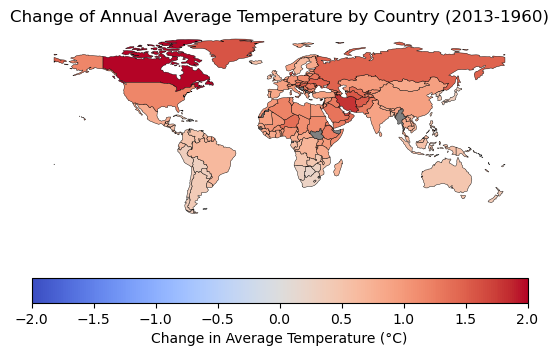

In [ ]:
missing_kwds = dict(color='grey', label='No Data')
fig, ax= plt.subplots(1,1)
deltaTempPlot = world.plot(column="delta_temp",
           ax=ax,
           legend=True,
            edgecolor='k',
            linewidth=0.3,
           cmap="coolwarm",
           legend_kwds={"label":"Change in Average Temperature (°C)",
                        "orientation":"horizontal"},
            vmin=-2,
            vmax=2,
            missing_kwds=missing_kwds)
plt.title("Change of Annual Average Temperature by Country (2013-1960)")
deltaTempPlot.set_axis_off()

As seen by the complete lack of blue in this heatmap, every single country in the world has experienced some form of increase in temperature over the last 50 years. It is of note that Canada seems to have the largest increase in temperature of all countries. From this graph it is hard to tell whether there are any "local" clumps where temperature change is larger than others. Let's use a kdeplot containing the change in temperature and split the data by continent

Text(0.5, 29.1406250000001, 'Change in Average Temperature from 1960-2013 (°C)')

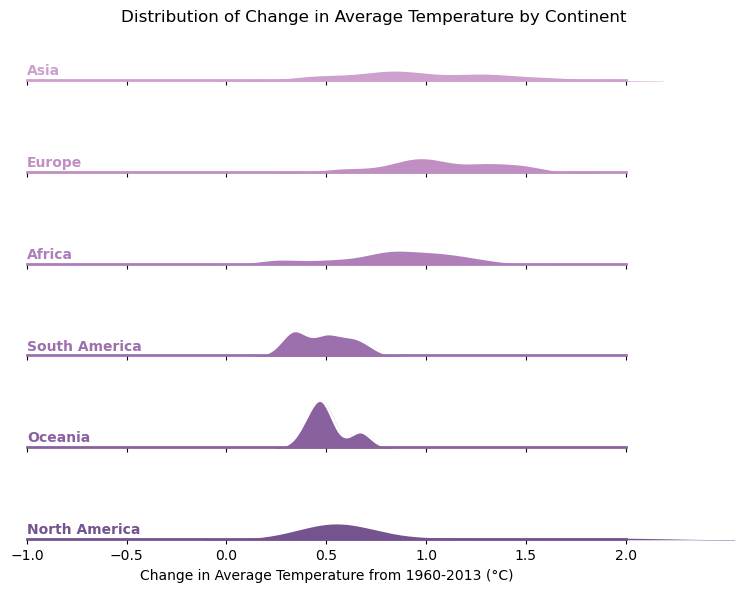

In [ ]:
#Parts of code used to tune this plot copied from this website: https://seaborn.pydata.org/examples/kde_ridgeplot
palette = sns.cubehelix_palette(10, rot=0.2, light=.7)
ridgeline = sns.FacetGrid(world,row="continent",hue="continent",aspect=8,height=1,palette=palette)
ridgeline.map(sns.kdeplot, "delta_temp", bw_adjust=.7, clip_on=False, fill=True, alpha=1, linewidth=1.5)
ridgeline.map(sns.kdeplot, "delta_temp", clip_on=False, color="w", lw=2, bw_adjust=.7)
ridgeline.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
plt.xlim(-1,2)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
ridgeline.map(label, "continent")

#Really not sure why but using this line to make the plots overlap totally breaks it unlike where I got the code from so I am just omitting it
#ridgeline.figure.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
ridgeline.set_titles("")
ridgeline.set(yticks=[], ylabel="")
ridgeline.despine(bottom=True, left=True)
ridgeline.fig.suptitle("Distribution of Change in Average Temperature by Continent")
plt.xlabel("Change in Average Temperature from 1960-2013 (°C)")

The findings in this plot are extremely interesting. Look how the Americas and Oceania are all clumped just as the tails of Asia, Europe, and Africa are forming. The tips of the former are ~0.5 degrees behind the latter. While 0.5 degrees may not sound like much, on a global scale, only a few degrees could completely change an ecosystem, potentially causing mass extinction as animals adapt. Geographically, the two clumps are close together (admittedly except for maybe Oceania) and could suggest that the Eastern hemisphere's temperature is increasing faster than the West.

Let's also analyze the the CO2 emissions over time, starting with a line plot.

Text(0.5, 1.0, 'CO2 Emissions Over Time by Continent')

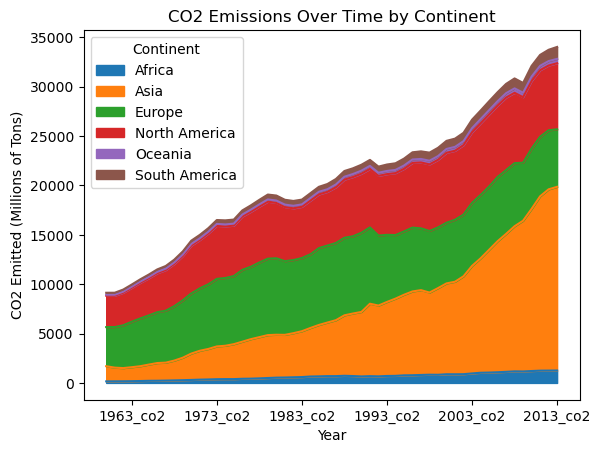

In [ ]:
labels = np.arange(0,100,15)
lineplot = world.groupby(by='continent').sum(numeric_only=True).iloc[:,2:56].transpose().plot.area(stacked=True,
                        xticks=[3,13,23,33,43,53],xlabel="Year",ylabel="CO2 Emitted (Millions of Tons)")
lineplot.legend(title='Continent')
plt.title("CO2 Emissions Over Time by Continent")

The most noticeable thing in this visualization is the change in how much CO2 Asia produces. This is due to the rapid modernization of Asia and China especially. Since China has such a large population to accompany this large shift in economic status, their CO2 output has exploded.

China may be the world's largest polluter, they also have the largest population. I want to compare the difference between the amount of CO2 produced with the amount produced **per person**. We can use geopandas once again for this.

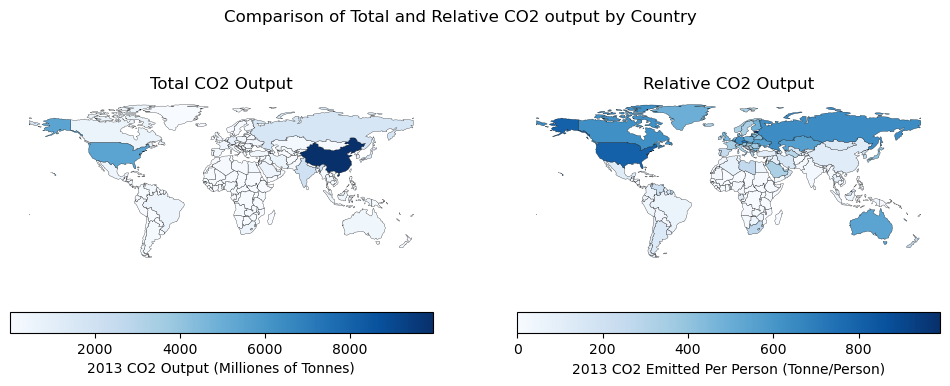

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12, 4))
totalco2 =world.plot(ax=ax1,column="2013_co2",cmap="Blues",legend=True,edgecolor='k',linewidth=0.2,  legend_kwds={"label":"2013 CO2 Output (Milliones of Tonnes)",
                        "orientation":"horizontal"},)
ax1.set_title("Total CO2 Output")
relativeco2 = world.plot(ax=ax2,column="Co2PerPerson(Tonnes)",cmap="Blues",legend=True,edgecolor='k',linewidth=0.2,  legend_kwds={"label":"2013 CO2 Emitted Per Person (Tonne/Person)",
                        "orientation":"horizontal"})
ax2.set_title("Relative CO2 Output")
fig.suptitle("Comparison of Total and Relative CO2 output by Country")
totalco2.set_axis_off()
relativeco2.set_axis_off()

In the Total CO2 plot, China and the U.S dominate all the saturation. In the relative plot however, China's blue fades significantly as european countries light up. This reflects the richness of European countries that do not show up on the left graph due to their small population relative to the world's superpowers.

# Answering Research Question

Now lets's begin answering my research Question. "Are countries that emmit more CO2 affected by climate change more than others?" I am going to use a scatterplot to compare the change in average temperature and total CO2 output for every country. Many countries have magnitudes smaller populations and land size, thus less total CO2 output so I will use a log scale on the y axis

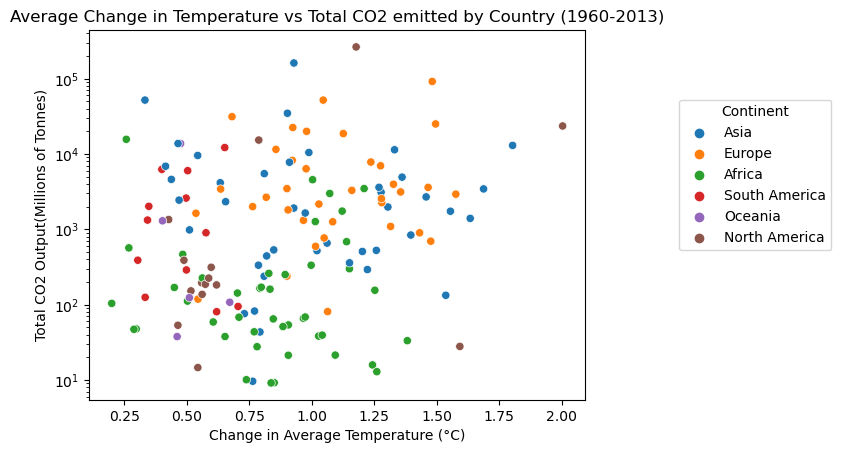

In [ ]:
scatter = sns.scatterplot(data=world,x="delta_temp",y="totalCo2",hue="continent")
scatter.set(title="Average Change in Temperature vs Total CO2 emitted by Country (1960-2013)",xlabel="Change in Average Temperature (°C)",
           ylabel="Total CO2 Output(Millions of Tonnes)")
scatter.legend(bbox_to_anchor=(1.05,1),loc="upper left", borderaxespad=5,title="Continent")
plt.yscale('log')

The resulting plot is extremely noisy. It would very foolish to confidently say there is a linear or logarithmic trend in this data. Now let's check the correlation between the two variables.

In [ ]:
correlation = world["delta_temp"].corr(world["totalCo2"])
correlation

0.10635739706826056

This is also a rather low correlation. However statistical tests should be conducted to determine if it is significant. Using the formula
$ t = \frac{r\sqrt{n-2}}{\sqrt{1-r^2}} $ we can plug in the number of countries for n and our correlation coefficient for r to recieve our test statistic.

In [ ]:
n = len(world["name"])
r = correlation
t = (r*(n-2)**(1/2)/(1-r**2)**(1/2))
t

1.4068930922898302

Using the scipy package, we can see what our test statistic must be in order to be significant. We will use a significance level of 95% (therefore alpha=1-0.95=0.05).

In [ ]:
from scipy import stats
alpha = 0.05
z_crit = stats.norm.ppf(1-alpha/2)
z_crit

1.959963984540054

 Since our test statistic is smaller than our required Z-score, we do not have sufficient evidence to conclude there is any sort of posive correlation between a countries emission output and their change of temperature. This result further solidifies that climate change is a global problem, and if only some countries strive to become netzero, nobody will reap the beneifits. That being said, just about every country on earth has pledged to reach net carbon zero between the years 2050-2100. Whether we reach this goal is an answer that can only be told with time, but the evidence I have found in this research further states the importance of **everyone** reaching this goal, not just some.